# 3D medical image segmentation with five clicks

This notebook shows how to use SAM 2 for interactive segmentation in 3D images. It will cover the following:

- adding clicks on a frame to get and refine _masklets_ (spatio-temporal masks) 
- propagating clicks to get _masklets_ throughout the video

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

len of frames:  76


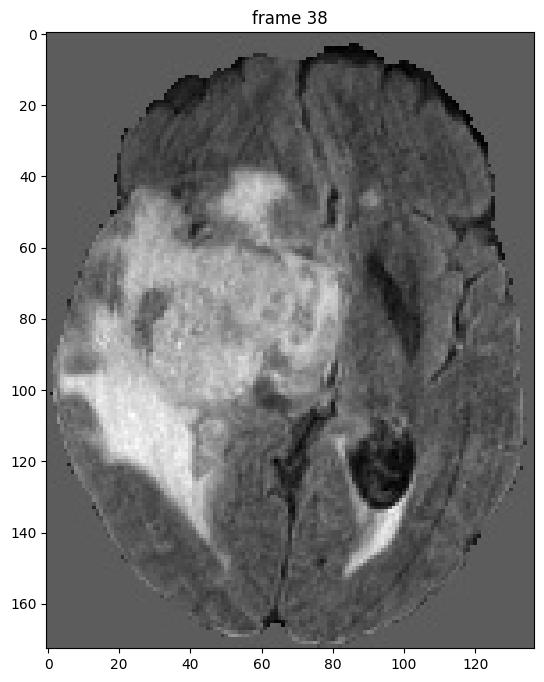

In [5]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/brats2020_001"
ann_obj_id = 1
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
# 对 frame_names 进行排序，按文件名（假设文件名仅为数字部分）进行升序排列，这样可以确保图像帧按照索引顺序排列
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

print("len of frames: ", len(frame_names))

# take a look the first video frame
frame_idx = len(frame_names) // 2
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx]))) #"./videos/brats2020_001/50.jpg"

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [6]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 76/76 [00:01<00:00, 45.52it/s]


load one mask

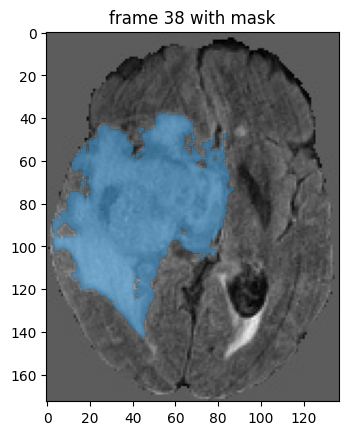

In [7]:
gt = np.load(os.path.join(video_dir, frame_names[frame_idx].replace(".jpg", ".npy"))) # 加载掩码文件
plt.title(f"frame {frame_idx} with mask")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
show_mask(gt, plt.gca())

In [8]:
from scipy import ndimage
# Find the largest enclosed point (center point of false area) in the mask 掩码内的中心点
def find_largest_enclosed_point(img, disturb=False):   
    # written by chatgpt4, and modified by yun 在掩码 img 的边缘填充一圈值为 0 的边框（1像素宽），用于确保距离变换时不忽略边缘像素
    img = np.pad(img, 1, mode='constant') 

    # Mark the connected area and divide all the foreground areas in the image into each connected area.
    # ndimage.label(img) 将 img 中所有的前景（即非零）像素划分为若干独立的连通区域，返回 label（标记图，每个连通区域被标记成唯一值）和 num_labels（连通区域的数量）
    label, num_labels = ndimage.label(img)
    max_distance = 1.42
    max_coordinate = (0, 0)

    for i in range(1, num_labels+1):
        # Set the current area to 1 and other areas to 0.
        region = (label == i).astype(int)
        # 使用 distance_transform_edt(region) 计算距离变换，生成 distance_transform 数组。该数组中的每个像素值表示它到最近边缘的距离
        distance_transform = ndimage.distance_transform_edt(region)
        
        # Find the maximum distance field value
        dist_max = np.max(distance_transform)
        
        # If the maximum distance field in the current region is greater than the existing maximum, the maximum value and the corresponding coordinates will be updated.
        # 找到该区域中最大距离 dist_max。如果 dist_max 大于 max_distance，则更新最大距离并记录对应坐标 max_coordinate
        if dist_max > max_distance:
            max_distance = dist_max
            max_coordinate = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
    
    if max_distance == 1.42:
        return max_distance, (None, None)
    # Return the coordinates of the maximum distance field value, pay attention to subtract the filled 1, and restore the original size.
    if not disturb:
        return max_distance, (max_coordinate[1] - 1, max_coordinate[0] - 1)
    else: #在最大距离坐标周围随机扰动坐标，尝试寻找邻近的一个像素。在 5 次扰动尝试内，如果扰动坐标仍在当前区域（region 中值为 1），则返回扰动后的坐标。若扰动次数用尽，返回去填充后的原坐标。
        retry = 5
        while retry > 0:
            retry -= 1
            disturb_x = np.random.randint(-5, 5)
            disturb_y = np.random.randint(-5, 5)
            if region[max_coordinate[0] + disturb_y, max_coordinate[1] + disturb_x] == 1:
                return max_distance, (max_coordinate[1] + disturb_x - 1, max_coordinate[0] + disturb_y - 1)
        return max_distance, (max_coordinate[1] - 1, max_coordinate[0] - 1)
        # 最大距离（max_distance）：找到的封闭点的距离值。
        # 坐标（(x, y)）：封闭点的坐标，表示图像内最靠近中心的区域。


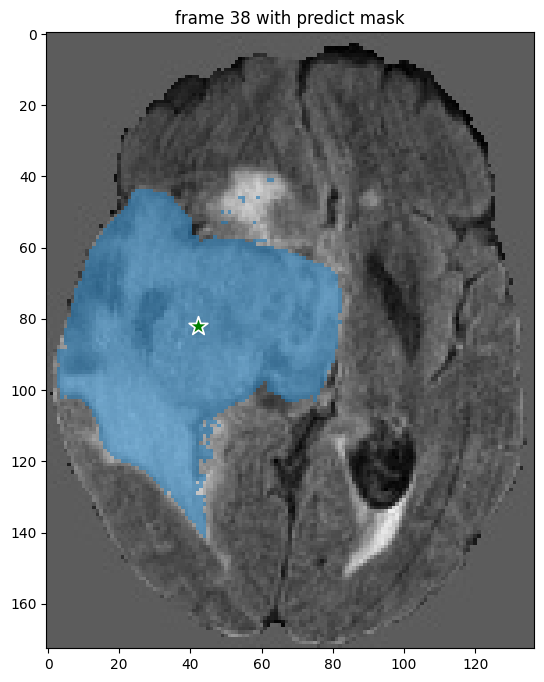

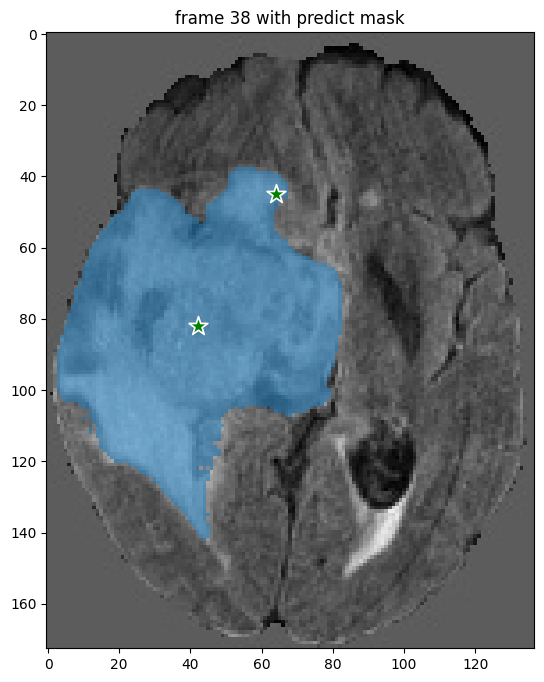

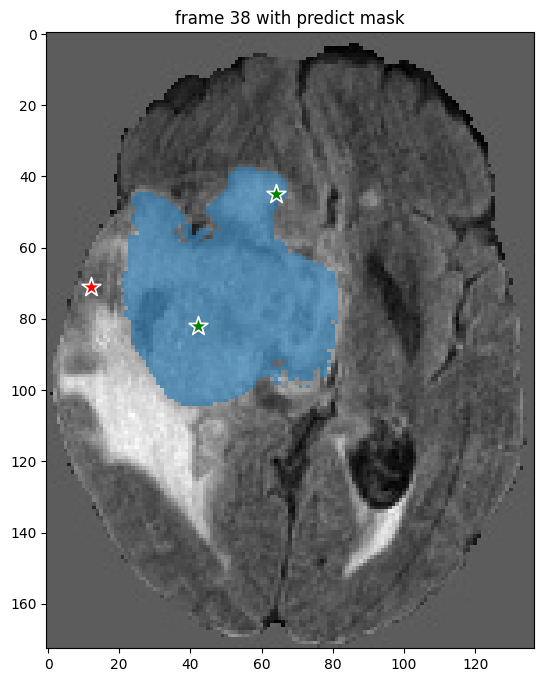

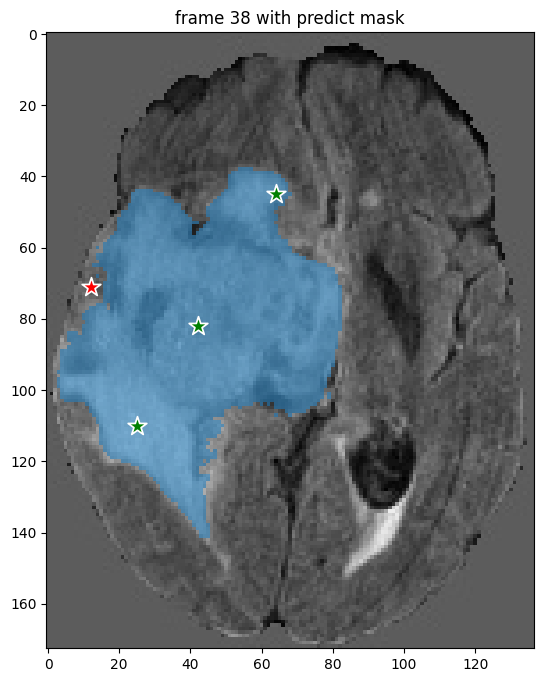

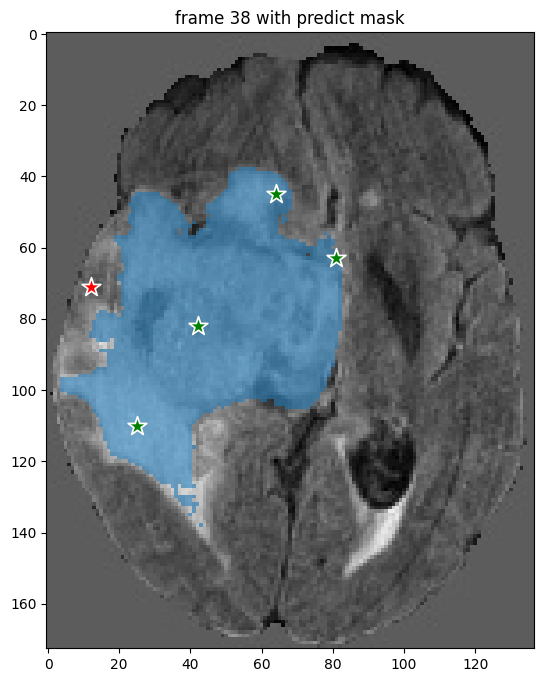

In [10]:
# 通过迭代方式生成分割掩码 out_mask，并逐步改进分割精度。每次迭代中，代码会分析当前的预测结果 out_mask，找到错误区域中的封闭点，然后根据该点的信息更新掩码，直到掩码接近目标掩码 gt
# Initial mask is full 0
points = np.array([], dtype=np.float32)
labels = np.array([], np.int32)
gt = np.load(os.path.join(video_dir, frame_names[frame_idx].replace(".jpg", ".npy")))
out_mask = np.zeros_like(gt)

# Define a function for an iteration.
# perform_iteration() 是一次迭代的核心函数，每次调用会改进 out_mask 的精度。
def perform_iteration():
    global points, labels, out_mask

    # 找到假阴性（FN）和假阳性（FP）区域
    FN = np.logical_and(gt, np.logical_not(out_mask))
    FP = np.logical_and(np.logical_not(gt), out_mask)
    assert len(FN.shape) == 2, len(FN.shape) == 2 

    # action == 0 or 1 查找最大封闭点
    max_dis_1, col_1 = find_largest_enclosed_point(FN, disturb=False)
    max_dis_2, col_2 = find_largest_enclosed_point(FP, disturb=False)
    if max_dis_1 >= max_dis_2:
        max_dis = max_dis_1
        col = col_1
        input_label = 1
    else:
        max_dis = max_dis_2
        col = col_2
        input_label = 0
    assert len(col) == 2

    if col[0] is None:
        return
    else: #如果 col 是有效坐标，则将其添加到 points 中，并将对应标签添加到 labels 中
        if points.size == 0:
            points = np.array([col], dtype=np.int32)
        else:
            points = np.append(points, [col], axis=0).astype(np.int32)
        labels = np.append(labels, input_label).astype(np.int32)
        
        # 添加新点进行掩码更新
        _, out_obj_ids, out_mask_logits = predictor.add_new_points(
            inference_state=inference_state,
            frame_idx=frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )

    plt.figure(figsize=(12, 8))
    plt.title(f"frame {frame_idx} with predict mask")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
    show_points(points, labels, plt.gca())
    show_mask(out_mask_logits.cpu() > 0.0, plt.gca())

    out_mask = (out_mask_logits.cpu() > 0.0)[0][0]

# loop 5 times
for _ in range(5):
    perform_iteration()

#### Propagate the prompts to get the masklet across the video

In [11]:
video_segments = {}  # video_segments contains the per-frame segmentation results
# 调用 predictor.propagate_in_video(inference_state) 方法遍历视频的每一帧，返回每一帧的索引 out_frame_idx、对象 ID 列表 out_obj_ids 以及分割结果 out_mask_logits
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    
    # 存储每帧的分割结果
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video:   0%|          | 0/38 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 38/38 [00:01<00:00, 23.95it/s]


In [12]:
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=frame_idx-1, reverse=True):
    
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 38/38 [00:01<00:00, 23.68it/s]


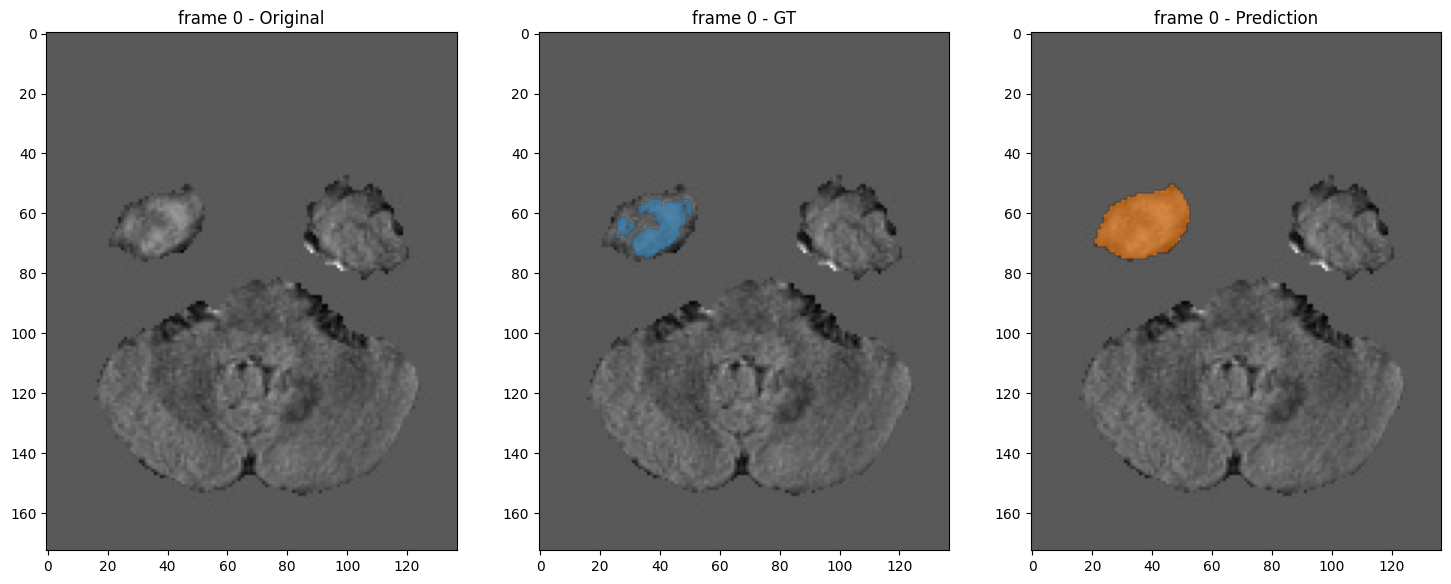

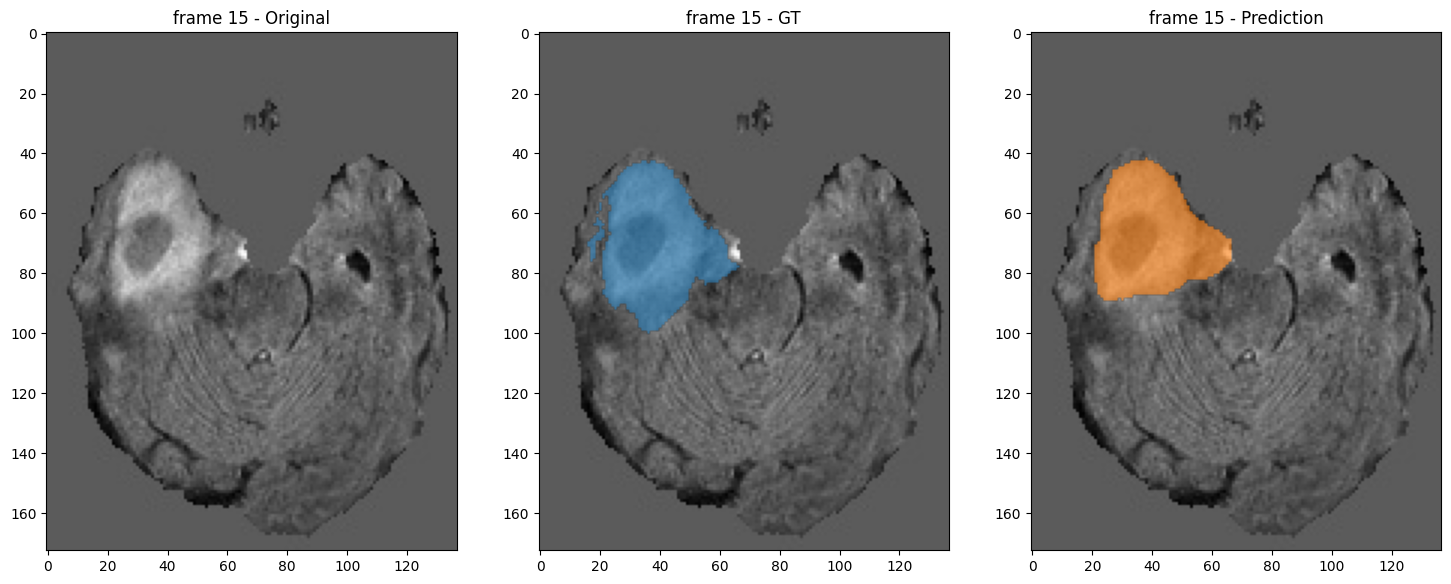

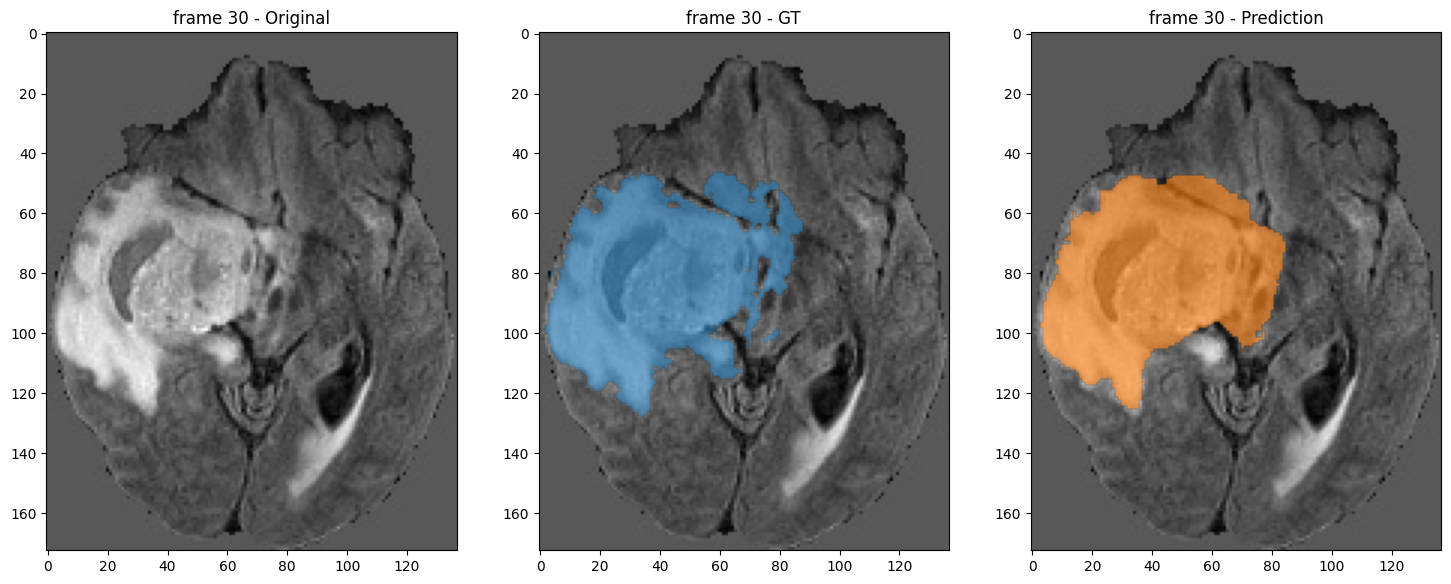

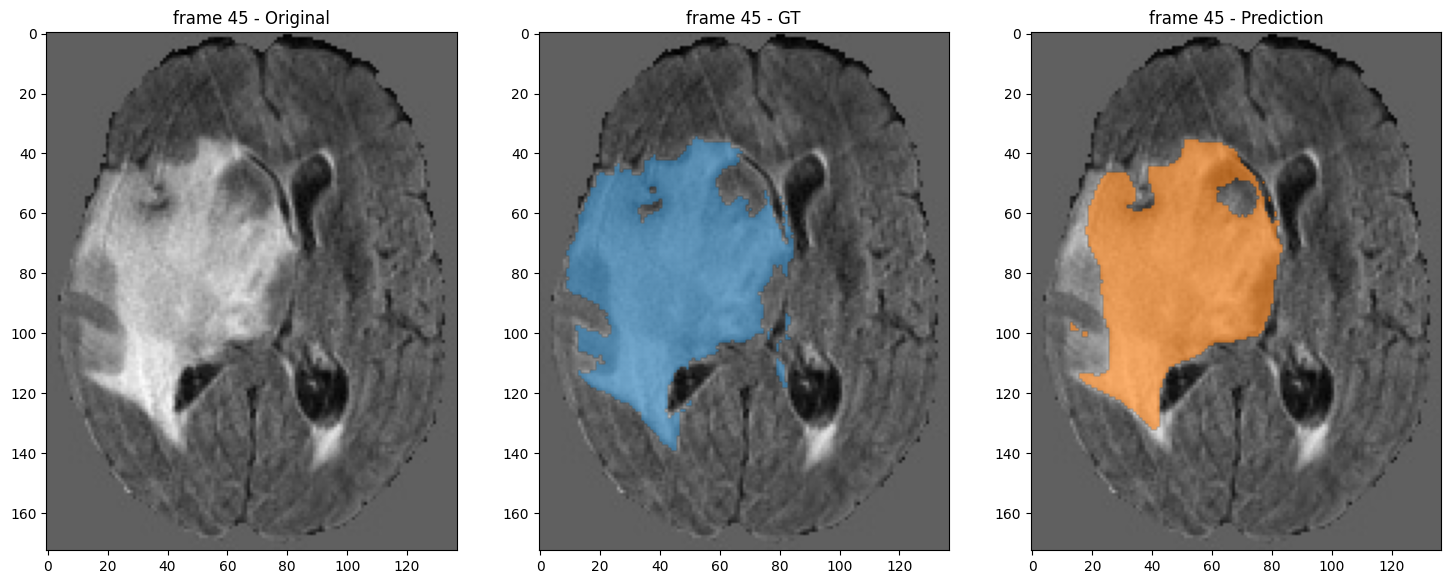

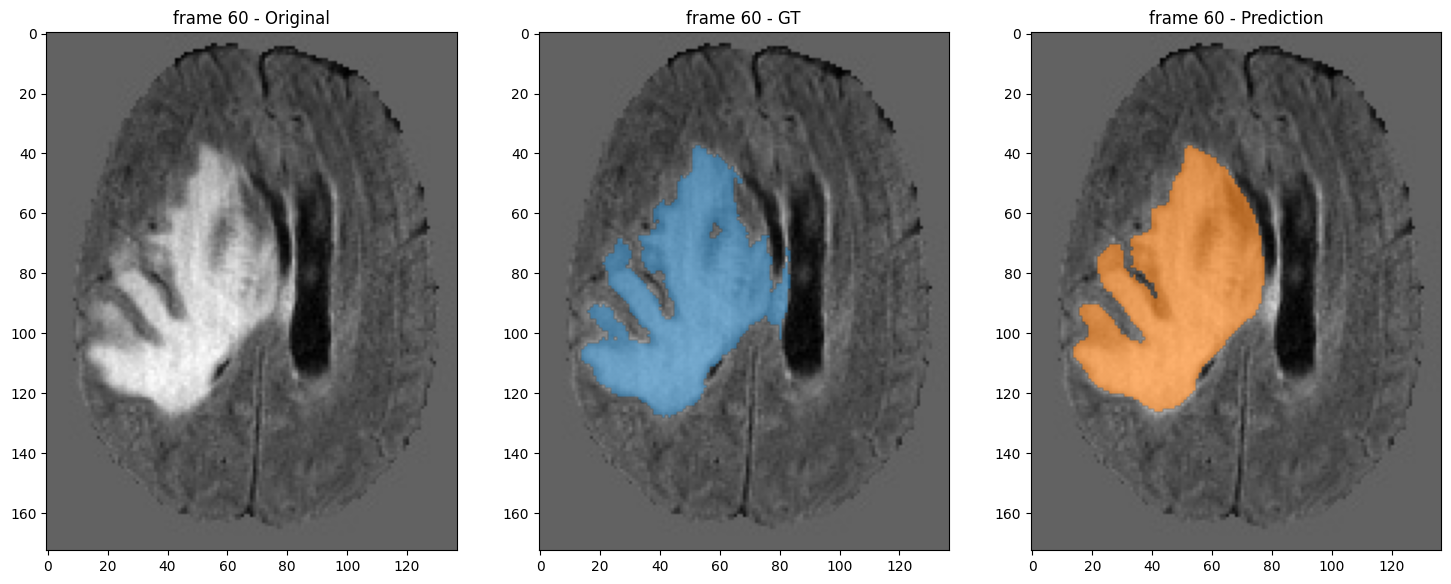

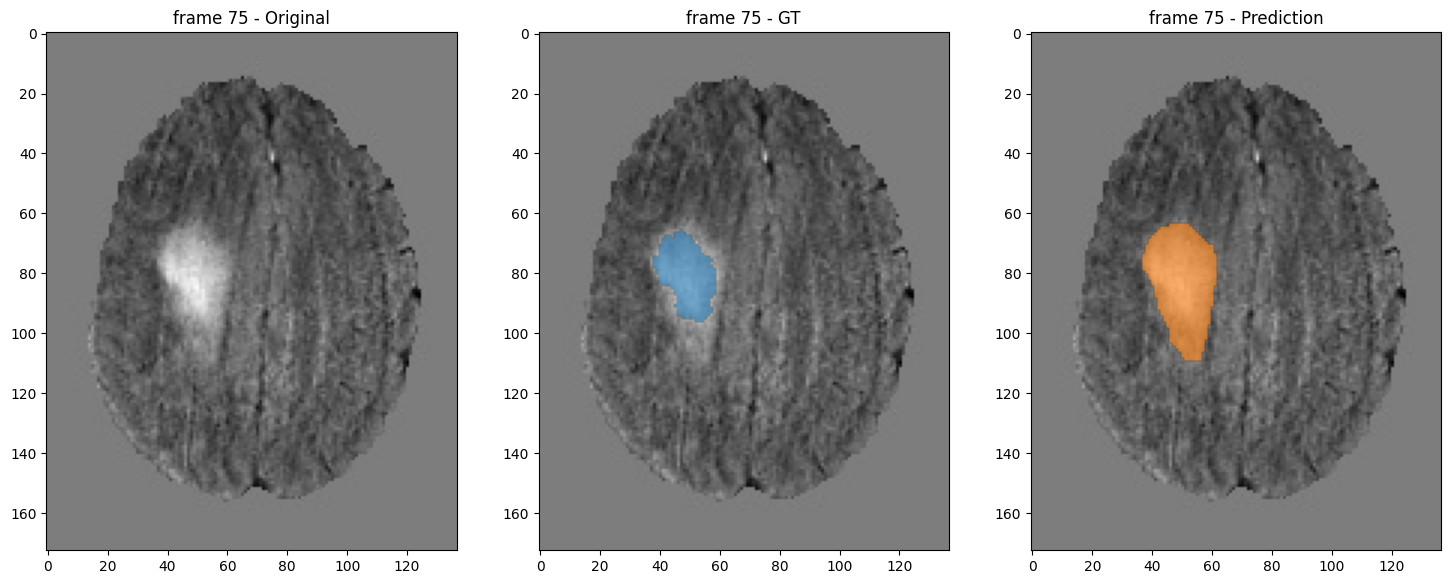

In [13]:
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # 修改为3个子图，调整figsize以适应更多的子图
    
    # 原图 subplot
    axes[0].set_title(f"frame {out_frame_idx} - Original")
    original_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[0].imshow(original_image)
    
    # Ground truth subplot
    axes[1].set_title(f"frame {out_frame_idx} - GT")
    gt_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[1].imshow(gt_image)
    out_mask_logits_gt = np.load(os.path.join(video_dir, frame_names[out_frame_idx].replace(".jpg", ".npy")))
    show_mask(out_mask_logits_gt, axes[1])
    
    # Predicted result subplot
    axes[2].set_title(f"frame {out_frame_idx} - Prediction")
    pred_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[2].imshow(pred_image)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, axes[2], obj_id=out_obj_id)
    
    plt.show()


In [14]:
video_seg_3d = np.stack([video_segments[k][1] for k in video_segments])
gt_3d = np.stack([np.load(os.path.join(video_dir, frame_names[k].replace(".jpg", ".npy")))[None] for k in video_segments])

In [15]:
import torch
from monai.metrics import DiceHelper, compute_surface_dice

n_classes, batch_size = 1, 1
spatial_shape = (video_seg_3d.shape[0], video_seg_3d.shape[2], video_seg_3d.shape[3]) 

y_pred = torch.tensor(video_seg_3d).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
y = torch.tensor(gt_3d).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth

score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
print('dice score:', score)

print('nsd score:', compute_surface_dice(y_pred, y, class_thresholds=[1]))

dice score: tensor([0.8861])
nsd score: tensor([[0.6605]])
